In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [3]:
df = pd.read_csv("data.csv")
df.head()

,Date of Visit,Patient ID,Service Type,Treatment Cost,Medication Cost,Follow-Up Scheduled,Patient Satisfaction Score,Referral Source,Emergency Visit,Payment Status,...,providerAge,Procedure,patientGender,patientAge,Race,Insurance Provider,Diagnosis,Department,patientCity,patientState
0,4/9/2025 0:00,1,Outpatient,127,99,NO,2,Physician Referral,No,Paid,...,37,CT Scan,Male,18,Hispanic,AXA,Fracture,Orthopedics,Edinburgh,Northern Ireland
1,6/23/2024 0:00,2,Emergency,624,171,NO,2,Physician Referral,Yes,Paid,...,35,Ultrasound,Male,19,Hispanic,Aviva,Asthma,General Surgery,London,Scotland
2,2/7/2025 0:00,3,Emergency,301,91,NO,8,Physician Referral,No,Paid,...,35,Ultrasound,Female,20,Asian,AXA,Asthma,Neurology,Edinburgh,Northern Ireland
3,9/15/2024 0:00,4,Outpatient,234,174,YES,3,Physician Referral,No,Paid,...,34,Blood Test,Male,20,Black,Allianz,Hypertension,Cardiology,Edinburgh,England
4,4/15/2024 0:00,5,Outpatient,621,27,YES,1,Emergency,No,Pending,...,35,CT Scan,Male,20,Asian,Allianz,Asthma,Cardiology,Edinburgh,England


# cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date of Visit               5000 non-null   object 
 1   Patient ID                  5000 non-null   int64  
 2   Service Type                5000 non-null   object 
 3   Treatment Cost              5000 non-null   int64  
 4   Medication Cost             5000 non-null   int64  
 5   Follow-Up Scheduled         5000 non-null   object 
 6   Patient Satisfaction Score  5000 non-null   int64  
 7   Referral Source             5000 non-null   object 
 8   Emergency Visit             5000 non-null   object 
 9   Payment Status              5000 non-null   object 
 10  Room Type                   5000 non-null   object 
 11  Insurance Coverage          5000 non-null   float64
 12  Room Charges(daily rate)    5000 non-null   int64  
 13  Provider Name               5000 

In [5]:
df['Date of Visit'] = pd.to_datetime(df['Date of Visit'])

In [6]:
df['total cost'] = df["Treatment Cost"] + df["Medication Cost"] + df["Room Charges(daily rate)"]

In [7]:
df.describe()
# Medication Cost and Treatment Cost random distripution cols
# but Treatment Cost more variation
# Patient Satisfaction is bad 
# and there exist more variation in Patient Satisfaction there exist patients stasifaied and not stasified 
# but most of them not stasified because mor than 50% of visits the patients not stasified 
# Insurance Coverage we can say there is nearly 200 bounds not covered and there exist partial covered and full covered visits
# Room Charges(daily rate):
# Some people pay very high rates, but this percentage is small.
# Most patients either do not require accommodation or are accommodated in economy rooms.
# Most of the providers are in the same age group.
# The service covers a wide age range.

,Date of Visit,Patient ID,Treatment Cost,Medication Cost,Patient Satisfaction Score,Insurance Coverage,Room Charges(daily rate),providerAge,patientAge,total cost
count,5000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2024-09-13 17:36:57.600000,2487.617200,526.081200,109.207800,3.840400,445.18474,14.634000,38.494800,48.805600,649.923000
min,2024-01-01 00:00:00,1.000000,50.000000,20.000000,1.000000,0.00000,0.000000,34.000000,18.000000,79.000000
25%,2024-05-04 18:00:00,1244.750000,284.000000,64.000000,1.000000,273.70000,0.000000,35.000000,34.000000,406.750000
50%,2024-09-06 12:00:00,2489.500000,525.000000,109.000000,2.000000,446.25000,0.000000,37.000000,49.000000,651.000000
75%,2025-01-09 06:00:00,3731.250000,765.000000,154.000000,6.000000,619.50000,30.000000,45.000000,64.000000,890.250000
max,2025-05-14 00:00:00,4973.000000,1000.000000,199.000000,10.000000,858.20000,50.000000,50.000000,79.000000,1226.000000
std,NaN,1435.369134,276.548485,52.001229,2.941064,206.67696,18.678753,5.108463,17.906991,281.625224


In [8]:
df.sort_values(by = ['Date of Visit','Patient ID'], inplace=True)
df['prev visits'] = df.groupby('Patient ID').cumcount()
df['prev emergency'] = df.groupby("Patient ID")['Emergency Visit'].cumcount()

df_sorted = df.sort_values(['Patient ID', 'Date of Visit'], ascending=[True, False])
df['last diagnose'] = df_sorted.groupby("Patient ID").nth(1)[["Diagnosis"]]
df['last diagnose'].fillna("none",inplace=True)

df['days_since_last_visit'] = df.groupby('Patient ID')['Date of Visit'].diff().dt.days
df['days_since_last_visit'] = df['days_since_last_visit'].fillna(0)

df['mean_score_history'] = (
    df.groupby("Patient ID")["Patient Satisfaction Score"]
      .transform(lambda x: x.shift().expanding().mean())
)
df['mean_score_history'].fillna(0,inplace= True)

bins = [0, 3, 7, 11] 
labels = ["bad","good",'very good'] 

df["Satisfaction_Category"] = pd.cut(
    df["Patient Satisfaction Score"],
    bins=bins,
    labels=labels,
    right=False
)
df[df['mean_score_history']>=1].sample(10)

C:\Users\omare\AppData\Local\Temp\ipykernel_26200\3950078439.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['last diagnose'].fillna("none",inplace=True)
C:\Users\omare\AppData\Local\Temp\ipykernel_26200\3950078439.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

,Date of Visit,Patient ID,Service Type,Treatment Cost,Medication Cost,Follow-Up Scheduled,Patient Satisfaction Score,Referral Source,Emergency Visit,Payment Status,...,Department,patientCity,patientState,total cost,prev visits,prev emergency,last diagnose,days_since_last_visit,mean_score_history,Satisfaction_Category
390,2025-02-02,388,Emergency,592,86,NO,5,Emergency,Yes,Pending,...,Neurology,Glasgow,Wales,708,1,1,none,300.0,1.0,good
3517,2024-12-29,3499,Outpatient,294,124,NO,9,Physician Referral,No,Pending,...,Cardiology,Birmingham,Wales,448,1,1,none,206.0,1.0,very good
499,2024-08-04,496,Inpatient,478,72,NO,5,Physician Referral,No,Pending,...,Orthopedics,Sheffield,Wales,560,1,1,none,213.0,2.0,good
2304,2024-08-07,2295,Outpatient,658,129,YES,7,Emergency,No,Pending,...,General Surgery,Edinburgh,England,787,1,1,none,188.0,2.0,very good
2508,2024-12-21,2496,Outpatient,691,164,YES,3,Emergency,No,Paid,...,Orthopedics,Glasgow,Northern Ireland,855,1,1,none,253.0,1.0,good
4166,2025-01-31,4144,Outpatient,669,34,NO,5,Physician Referral,Yes,Paid,...,Cardiology,Leeds,Scotland,733,2,2,none,146.0,1.5,good
1477,2025-03-07,1471,Outpatient,590,88,YES,5,Emergency,Yes,Paid,...,Pediatrics,Birmingham,Wales,678,1,1,none,61.0,8.0,good
3129,2024-09-24,3113,Inpatient,118,114,YES,3,Physician Referral,No,Paid,...,Neurology,Birmingham,Scotland,232,1,1,none,43.0,2.0,good
4138,2025-01-20,4118,Outpatient,99,153,NO,5,Emergency,Yes,Pending,...,Neurology,Sheffield,Wales,302,1,1,none,335.0,1.0,good
2374,2025-02-26,2364,Emergency,254,35,YES,2,Self-Referral,Yes,Paid,...,Cardiology,Glasgow,Northern Ireland,289,1,1,none,156.0,10.0,bad


In [9]:
lab = LabelEncoder()
stringCols = df.select_dtypes([object,'datetime64',"category"]).columns
lab_classes = {}
for col in stringCols:
    df[col] = lab.fit_transform(df[col])
    lab_classes[col] = lab.classes_

In [23]:
stringCols

Index(['Date of Visit', 'Service Type', 'Follow-Up Scheduled',
       'Referral Source', 'Emergency Visit', 'Payment Status', 'Room Type',
       'Provider Name', 'providerGender', 'Nationality', 'Procedure',
       'patientGender', 'Race', 'Insurance Provider', 'Diagnosis',
       'Department', 'patientCity', 'patientState', 'last diagnose',
       'Satisfaction_Category'],
      dtype='object')

In [11]:
x = df.drop(columns=['Emergency Visit','Medication Cost','Treatment Cost','total cost','Patient Satisfaction Score','Insurance Coverage'])
y = df['Emergency Visit']
model = RandomForestClassifier()
model.fit(x,y)

importances = pd.Series(model.feature_importances_,index=x.columns)
importances.sort_values(ascending=False, inplace=True)
print(importances)
top10feat = importances.head(10).index

Date of Visit               0.186507
Patient ID                  0.124971
patientAge                  0.109487
patientCity                 0.056148
Race                        0.053485
Department                  0.043939
Procedure                   0.043252
Diagnosis                   0.041509
Referral Source             0.036867
Insurance Provider          0.036632
patientState                0.036007
Service Type                0.030365
Satisfaction_Category       0.027209
Room Type                   0.024664
Room Charges(daily rate)    0.023808
providerAge                 0.022441
Provider Name               0.021987
Payment Status              0.021650
patientGender               0.021278
Nationality                 0.014109
Follow-Up Scheduled         0.010026
providerGender              0.009057
last diagnose               0.001326
mean_score_history          0.000910
days_since_last_visit       0.000886
prev emergency              0.000759
prev visits                 0.000721
d

In [ ]:
x = x[top10feat]
x_train,  x_test ,y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [14]:
models = {
    'RandomForestClassifier':RandomForestClassifier(),
    'XGBoost' : XGBClassifier(),
    'Logistic' : LogisticRegression(),
    'DecisionTreeClassifier' : DecisionTreeClassifier()
}
results = []
for name, model in models.items():
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    Accuracy= accuracy_score(y_test, y_pred)
    Precision= precision_score(y_test, y_pred)
    Recall = recall_score(y_test, y_pred)
    F1_score = f1_score(y_test, y_pred)

    results.append({
        'name' : name,
        'Accuracy' : Accuracy,
        'Precision' : Precision,
        'Recall' : Recall,
        'F1_score' : F1_score
    })
results = pd.DataFrame(results)
results.sort_values(by ='Recall' , ascending=False , inplace=True)
results

d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,name,Accuracy,Precision,Recall,F1_score
1,XGBoost,0.618,0.495751,0.461741,0.478142
3,DecisionTreeClassifier,0.606,0.479339,0.459103,0.469003
0,RandomForestClassifier,0.636,0.528302,0.369393,0.434783
2,Logistic,0.620,0.333333,0.002639,0.005236


<Axes: xlabel='Patient Satisfaction Score', ylabel='Count'>

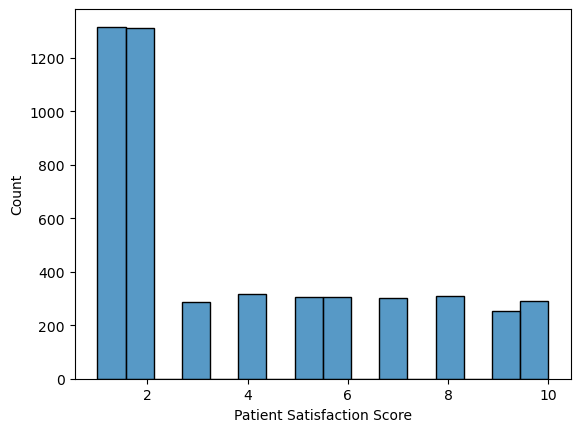

In [15]:
sns.histplot(df['Patient Satisfaction Score'])

In [16]:
# ML Patient Satisfaction Score
stasification = df.corr()["Patient Satisfaction Score"].sort_values(ascending=False)
stasification

Patient Satisfaction Score    1.000000
Satisfaction_Category         0.954994
Date of Visit                 0.571705
providerGender                0.315408
Department                    0.228930
Procedure                     0.183653
providerAge                   0.104982
Diagnosis                     0.101613
patientState                  0.090584
Payment Status                0.087388
days_since_last_visit         0.036275
last diagnose                 0.031755
Patient ID                    0.027704
Insurance Coverage            0.026990
prev emergency                0.023301
prev visits                   0.023301
mean_score_history            0.021399
Treatment Cost                0.019569
total cost                    0.018874
Referral Source               0.010715
patientGender                 0.010337
Insurance Provider            0.008986
Room Charges(daily rate)      0.004690
Follow-Up Scheduled           0.003688
Room Type                     0.001960
Medication Cost          

In [17]:
x = df.drop(columns=['Patient Satisfaction Score','Satisfaction_Category'])
y = df['Patient Satisfaction Score']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [18]:
# regrition 
models = {
    "LinearRegression" : LinearRegression(),
    "LogisticRegression" : LogisticRegression(),
    "DecisionTreeRegressor" : DecisionTreeRegressor(),
    "RandomForestRegressor" : RandomForestRegressor()
}
results = []

for name, model in models.items():
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test,y_pred).round(2)
    MAE = mean_absolute_error(y_test,y_pred).round(2)
    MSE = mean_squared_error(y_test,y_pred).round(2)
    RMSE = np.sqrt(MSE).round(2)
    NRMSE = (RMSE / y_test.mean()).round(2)
    results.append({
      "name" : name,
      "r^2" : r2,
      "MAE" : MAE,
      "MSE" : MSE,
      "RMSE" : RMSE,
      "NRMSE" : NRMSE
    })
results = pd.DataFrame(results)
results.sort_values(by ='r^2' , ascending=False , inplace=True)
results

d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,name,r^2,MAE,MSE,RMSE,NRMSE
3,RandomForestRegressor,0.40,1.56,4.91,2.22,0.59
0,LinearRegression,0.35,1.74,5.36,2.32,0.62
2,DecisionTreeRegressor,-0.12,1.95,9.15,3.02,0.81
1,LogisticRegression,-0.38,2.29,11.29,3.36,0.90


In [19]:
y = df['Satisfaction_Category']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [20]:
model = XGBClassifier()
model.fit(x,y)

importances = pd.Series(model.feature_importances_,index=x.columns)
importances.sort_values(ascending=False, inplace=True)
imp = importances.head(20).index

In [21]:
x = df[imp]

In [22]:
models = {
    'RandomForestClassifier':RandomForestClassifier(),
    'XGBoost' : XGBClassifier(),
    'Logistic' : LogisticRegression(),
    'DecisionTreeClassifier' : DecisionTreeClassifier()
}
results = []
for name, model in models.items():
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    Accuracy= accuracy_score(y_test, y_pred)
    Precision= precision_score(y_test, y_pred,average='macro')
    Recall = recall_score(y_test, y_pred,average='macro')
    F1_score = f1_score(y_test, y_pred,average='macro')

    results.append({
        'name' : name,
        'Accuracy' : Accuracy,
        'Precision' : Precision,
        'Recall' : Recall,
        'F1_score' : F1_score
    })
results = pd.DataFrame(results)
results.sort_values(by ='Recall' , ascending=False , inplace=True)
results

d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,name,Accuracy,Precision,Recall,F1_score
0,RandomForestClassifier,0.650,0.591586,0.591896,0.587405
1,XGBoost,0.647,0.581770,0.583213,0.580001
3,DecisionTreeClassifier,0.617,0.533074,0.531647,0.532218
2,Logistic,0.606,0.504954,0.501212,0.497037
